# Transcription factor motif matches on STARR-seq dataset

We will match the results of a genome-wide scan of transcription factor binding profiles to the sequence bins of a STARRseq dataset, and explore the resulting hits.

## Setup

### Imports

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import duckdb
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

### Paths for data and databases

In [3]:
PROJECT_ROOT = Path('/hpc/group/igvf')
DB_ROOT = PROJECT_ROOT / 'db'
DATA_ROOT = Path('../igvf-pm')
MOTIFS_DB = DB_ROOT / 'motifs'
STARR_DS = 'K562'
STARR_DB = DB_ROOT / f'{STARR_DS}db'

## TF motif matches from genome-wide scan

Open the database of significant matches (currently defined as p≤1e-8, corresponding to a q-value of ~0.05).

In [ ]:
motifs_db_signif = duckdb.read_parquet(f'{MOTIFS_DB}-signif.parquet')

### Number of motif matches

In [5]:
motifs_db_signif.count('motif_id')

┌─────────────────┐
│ count(motif_id) │
│      int64      │
├─────────────────┤
│          723249 │
└─────────────────┘

### Number of matches per motif

In [6]:
motif_matches = duckdb.sql(
    'select motif_id, regexp_extract(motif_alt_id, \'\.([^\.]+)$\', 1) as motif_name, '
    'count(*) as num_matches, '
    'from motifs_db_signif '
    'group by motif_id, motif_alt_id '
    'order by count(*) desc').df()
with pd.option_context('display.max_rows', None):
    display(motif_matches)

,motif_id,motif_name,num_matches
0,MA1596.1,ZNF460,439545
1,MA0149.1,EWSR1-FLI1,132769
2,MA1718.1,ZNF8,54149
3,MA1594.1,ZNF382,20845
4,MA2335.1,ZNF558,14191
5,MA1978.2,ZNF354A,11770
6,MA0080.5,SPI1,11728
7,MA1589.2,ZNF140,5572
8,MA1587.1,ZNF135,4622
9,MA1654.2,ZNF16,1805


### TF pairs within ≤K bp of each other

Loosely inspired by the typical insert length in STARRseq experiments, we set K = 1000.

In [7]:
TFpairs = duckdb.sql('select m1.chrom, m1.start, m1.stop - m1.start as motif_length, '
           'm1.motif_id, regexp_extract(m1.motif_alt_id, \'\.([^\.]+)$\', 1) as motif_name, '
           'm2.motif_id as motif2_id, regexp_extract(m2.motif_alt_id, \'\.([^\.]+)$\', 1) as motif2_name, '
           'm2.start - m1.start as motif_distance '
           'from motifs_db_signif m1 join motifs_db_signif m2 '
           'on (m1.chrom = m2.chrom and m1.stop < m2.start and m1.start + 1000 >= m2.stop)').df()
TFpairs

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,chrom,start,motif_length,motif_id,motif_name,motif2_id,motif2_name,motif_distance
0,chr1,7995162,17,MA0149.1,EWSR1-FLI1,MA1596.1,ZNF460,744
1,chr1,7995162,17,MA0149.1,EWSR1-FLI1,MA0149.1,EWSR1-FLI1,81
2,chr1,7995162,17,MA0149.1,EWSR1-FLI1,MA0149.1,EWSR1-FLI1,77
3,chr1,7995162,17,MA0149.1,EWSR1-FLI1,MA0149.1,EWSR1-FLI1,20
4,chr1,7988162,15,MA1596.1,ZNF460,MA1596.1,ZNF460,383
...,...,...,...,...,...,...,...,...
790253,chrY,25512817,15,MA1596.1,ZNF460,MA1596.1,ZNF460,136
790254,chrY,25496667,15,MA1596.1,ZNF460,MA1596.1,ZNF460,144
790255,chrY,25453236,19,MA1718.1,ZNF8,MA2335.1,ZNF558,443
790256,chrY,25444063,19,MA0080.5,SPI1,MA1594.1,ZNF382,876


#### TF pair statistics

In [45]:
TFpair_stats = duckdb.sql('select motif_id, motif_name, motif2_name, '
           'count(*) as numpairs, '
           'min(motif_distance) as min_distance, '
           'max(motif_distance) as max_distance, '
           'median(motif_distance) as median_distance, '
           'round(avg(motif_distance), 1) as avg_distance '
           'from TFpairs '
           'group by motif_id, motif_name, motif2_name '
           'having numpairs > 1 '
           'order by motif_name').df()
TFpair_stats

,motif_id,motif_name,motif2_name,numpairs,min_distance,max_distance,median_distance,avg_distance
0,MA0007.2,AR,ZNF460,18,53,968,712.0,657.3
1,MA1470.2,BACH2,ZNF460,7,245,447,311.0,333.0
2,MA0731.1,BCL6B,ZNF135,2,717,883,800.0,800.0
3,MA0731.1,BCL6B,ZNF460,10,271,807,624.0,556.2
4,MA1929.2,CTCF,RFX2,2,815,815,815.0,815.0
...,...,...,...,...,...,...,...,...
623,MA2100.1,ZSCAN16,EWSR1-FLI1,6,48,72,58.0,58.7
624,MA1722.2,ZSCAN31,ZNF8,2,189,479,334.0,334.0
625,MA1722.2,ZSCAN31,ZNF460,11,213,849,449.0,474.3
626,MA1155.1,ZSCAN4,EWSR1-FLI1,17,717,777,745.0,745.9


#### Some pairs occur 1000s of times

In [49]:
TFpair_stats[TFpair_stats['numpairs'] > 1000]

,motif_id,motif_name,motif2_name,numpairs,min_distance,max_distance,median_distance,avg_distance
63,MA0149.1,EWSR1-FLI1,EWSR1-FLI1,523882,18,983,68.0,126.2
64,MA0149.1,EWSR1-FLI1,ZNF460,27508,21,985,414.0,469.0
90,MA0149.1,EWSR1-FLI1,ZNF8,1321,20,981,653.0,654.4
262,MA0080.5,SPI1,ZNF382,3727,136,977,876.0,868.8
316,MA1587.1,ZNF135,ZNF460,1747,22,985,419.0,437.7
341,MA1589.2,ZNF140,ZNF460,1114,65,985,590.0,574.8
404,MA1594.1,ZNF382,SPI1,3751,111,979,880.0,873.6
434,MA1596.1,ZNF460,ZNF460,152847,16,985,426.0,448.1
457,MA1596.1,ZNF460,ZNF558,1055,52,971,563.0,557.4
468,MA1596.1,ZNF460,ZNF8,4894,50,981,588.5,584.9


#### But most occur <50 times

Text(0.5, 1.0, 'Distribution of multiply occurring TF pairs')

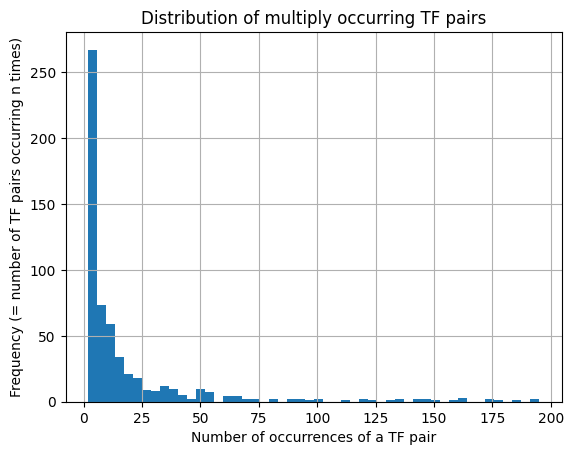

In [62]:
TFpair_stats[TFpair_stats['numpairs'] <= 200].hist(column='numpairs', bins=50)
plt.xlabel('Number of occurrences of a TF pair')
plt.ylabel('Frequency (= number of TF pairs occurring n times)')
plt.title('Distribution of multiply occurring TF pairs')

#### Distribution of motif pair distances in TF pairs

(1000.0, 100000.0)

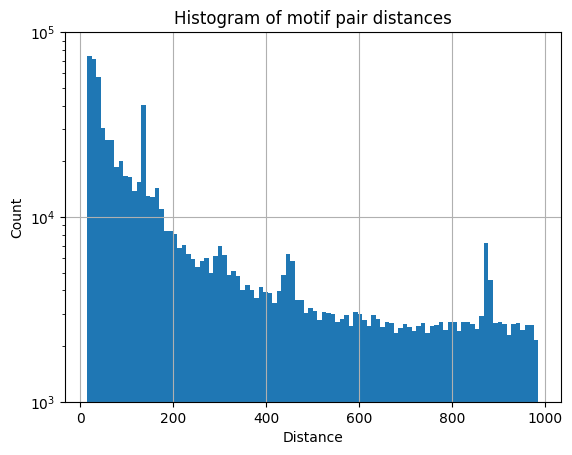

In [9]:
ax = TFpairs.hist('motif_distance', bins=100)[0][0]
ax.set_title('Histogram of motif pair distances')
ax.set_xlabel('Distance')
ax.set_ylabel('Count')
ax.set_yscale('log')
ax.set_ylim(1e3, 1e5)

This could suggest that there is a bias towards shorter distances, but it turns out the distribution in the short distance range is dominated by a single TF pair (EWSR1-FLI1 paired with itself). Once we remote this, there is no clear bias anymore.

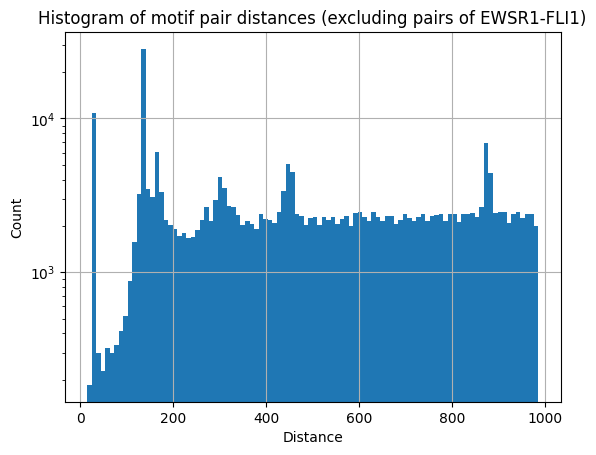

In [10]:
TFpairs_filtered = TFpairs.loc[~((TFpairs['motif_id'] == 'MA0149.1') & (TFpairs['motif2_id'] == 'MA0149.1'))]        
ax = TFpairs_filtered.hist('motif_distance', bins=100)[0][0]
ax.set_title('Histogram of motif pair distances (excluding pairs of EWSR1-FLI1)')
ax.set_xlabel('Distance')
ax.set_ylabel('Count')
ax.set_yscale('log')

## Motif matches mapped to STARRseq sequence bins

Load the STARRseq data:

In [43]:
data_db = duckdb.read_parquet(f"{STARR_DB}/**/*.parquet",
                              hive_partitioning=True)

Match motif matches to STARRseq sequence bins. We require that a motif lies fully within the sequence bin.

In [ ]:
hits_db = duckdb.sql('select d.chrom, d.start as seq_start, d.end as seq_end, '
           'm.motif_id, m.motif_alt_id, m.start as mot_start, m.stop as mot_stop, d.log2FC, d.train, d.test '
           'from data_db as d '
           'join motifs_db_signif as m '
           'on (d.chrom = m.chrom and d.start <= m.start and d.end >= m.stop)')
hits_db.to_parquet(f'{MOTIFS_DB}-{STARR_DS}_hits.parquet')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

We write this to a Parquet database so we can easily reload it later:

In [11]:
hits_db = duckdb.read_parquet(f'{MOTIFS_DB}-{STARR_DS}_hits.parquet')

How many sequence bins with at least one TF motif match do we have?

In [12]:
hits_db.count('chrom')

┌──────────────┐
│ count(chrom) │
│    int64     │
├──────────────┤
│       922087 │
└──────────────┘

### Number of matching sequence bins per TF motif 

In [13]:
hit_stats = duckdb.sql('select mh.motif_id, regexp_extract(mh.motif_alt_id, \'\.([^\.]+)$\', 1) as motif_name, '
           'count(*) as num_hits, '
           'count(case when train = \'true\' then 1 else NULL end) as train_hits, '
           'count(case when test = \'true\' then 1 else NULL end) as test_hits '
           'from hits_db mh '
           'group by mh.motif_id, mh.motif_alt_id '
           'order by count(*) desc').df()
with pd.option_context('display.max_rows', None):
    display(hit_stats)

,motif_id,motif_name,num_hits,train_hits,test_hits
0,MA1596.1,ZNF460,675668,90134,87223
1,MA0149.1,EWSR1-FLI1,68472,8999,9455
2,MA1718.1,ZNF8,64020,8399,8154
3,MA1587.1,ZNF135,9050,1235,1218
4,MA1589.2,ZNF140,8661,1148,1110
5,MA1654.2,ZNF16,7903,1058,1045
6,MA1573.1,THAP11,6507,863,867
7,MA1929.2,CTCF,4673,614,662
8,MA1930.2,CTCF,4409,624,597
9,MA1723.2,PRDM9,3966,527,531


### Sequence bins with combinations of different TF motifs

We consider TF motifs different if their Motif IDs are different. (Different motif IDs can still have the same name as a part of their _alt ID_.) When ordering the motifs by position, we require that the last motif falling into a sequence bin starts after the first motif falling into the bin ends. I.e., at least the first and the last don't overlap.

In [14]:
TFcomb_hits = duckdb.sql('select chrom, seq_start, seq_end, '
           'count(*) as num_hits, count(distinct motif_id) as num_tfs, '
           'max(mot_start) - min(mot_start) as motif_dist, '
           'group_concat(regexp_extract(motif_alt_id, \'\.([^\.]+)$\', 1), \', \') as motif_names, '
           'first(log2FC) as log2FC, '
           'first(case when train = \'true\' then TRUE else FALSE end) as train, '
           'first(case when test = \'true\' then TRUE else FALSE end) as test, '
           'from hits_db mh '
           'group by chrom, seq_start, seq_end '
           'having num_tfs > 1 and max(mot_start) > min(mot_stop) '
           'order by chrom, seq_start').df()
TFcomb_hits.to_csv(f'{MOTIFS_DB}-{STARR_DS}_TFcomb_hits.csv', index=False)
TFcomb_hits

,chrom,seq_start,seq_end,num_hits,num_tfs,motif_dist,motif_names,log2FC,train,test
0,chr1,181550,181850,3,2,58,"CTCF, CTCF, CTCF",0.13608,False,True
1,chr1,1841704,1842004,2,2,145,"ZNF8, ZNF140",-0.00571,False,False
2,chr1,1841754,1842054,2,2,145,"ZNF8, ZNF140",-0.10168,True,False
3,chr1,1841804,1842104,2,2,145,"ZNF8, ZNF140",-0.18042,False,False
4,chr1,3635504,3635804,2,2,33,"ZNF135, ZNF460",-0.25996,False,False
...,...,...,...,...,...,...,...,...,...,...
5765,chrX,154722924,154723224,3,2,136,"ZNF460, THRA, ZNF460",-0.06913,False,False
5766,chrX,154722974,154723274,3,2,136,"ZNF460, THRA, ZNF460",-0.11514,False,False
5767,chrX,154723024,154723324,2,2,21,"ZNF460, THRA",-0.22140,False,False
5768,chrX,154723074,154723374,2,2,21,"ZNF460, THRA",-0.29565,False,False


#### Some statistics for TF combinations

In [15]:
TFcomb_hits.describe()

,seq_start,seq_end,num_hits,num_tfs,motif_dist,log2FC
count,5.770000e+03,5.770000e+03,5770.000000,5770.000000,5770.000000,5770.000000
mean,6.928597e+07,6.928627e+07,2.661698,2.022357,128.276083,-0.179042
std,5.359400e+07,5.359400e+07,1.805580,0.201449,64.551706,0.318109
min,1.482000e+05,1.485000e+05,2.000000,2.000000,18.000000,-1.198080
25%,2.884361e+07,2.884391e+07,2.000000,2.000000,82.000000,-0.385047
50%,5.662877e+07,5.662907e+07,2.000000,2.000000,138.500000,-0.197350
75%,1.010927e+08,1.010930e+08,2.000000,2.000000,167.000000,0.001100
max,2.479370e+08,2.479373e+08,18.000000,6.000000,281.000000,1.899250


TF combinations that are (and are not) included in the training set and the test set:

In [16]:
TFcomb_hits['train'].value_counts()

train
False    4997
True      773
Name: count, dtype: int64

In [17]:
TFcomb_hits['test'].value_counts()

test
False    4988
True      782
Name: count, dtype: int64

#### TF combinations with $\log_2(\theta)>0.5$

In [18]:
with pd.option_context('display.max_rows', None):
    display(TFcomb_hits[TFcomb_hits['log2FC'] > 0.5].reset_index(drop=True))

,chrom,seq_start,seq_end,num_hits,num_tfs,motif_dist,motif_names,log2FC,train,test
0,chr1,12604547,12604847,3,3,203,"ZNF460, RARA::RXRG, RARA::RXRA",1.37339,False,False
1,chr1,12604597,12604897,3,3,203,"ZNF460, RARA::RXRG, RARA::RXRA",1.21637,False,False
2,chr1,26387347,26387647,2,2,70,"ZNF135, ZNF460",0.90187,False,True
3,chr1,26387397,26387697,2,2,70,"ZNF135, ZNF460",0.87963,False,False
4,chr1,26387447,26387747,2,2,70,"ZNF135, ZNF460",0.82521,False,False
5,chr1,26387497,26387797,2,2,70,"ZNF135, ZNF460",0.73022,False,False
6,chr1,27348847,27349147,4,4,18,"PPARD, RXRG, PPARG::RXRA, NR2C2",0.68202,False,False
7,chr1,27348897,27349197,4,4,18,"PPARD, RXRG, PPARG::RXRA, NR2C2",0.62628,False,False
8,chr1,27348947,27349247,4,4,18,"PPARD, RXRG, PPARG::RXRA, NR2C2",0.59434,False,False
9,chr1,27348997,27349297,4,4,18,"PPARD, RXRG, PPARG::RXRA, NR2C2",0.59092,False,False


#### $\log_2(\theta)$ distribution for sequence bins with TF motif hits

We compare all sequence bins with TF motif hit(s) with those with a combination of TF motifs. 

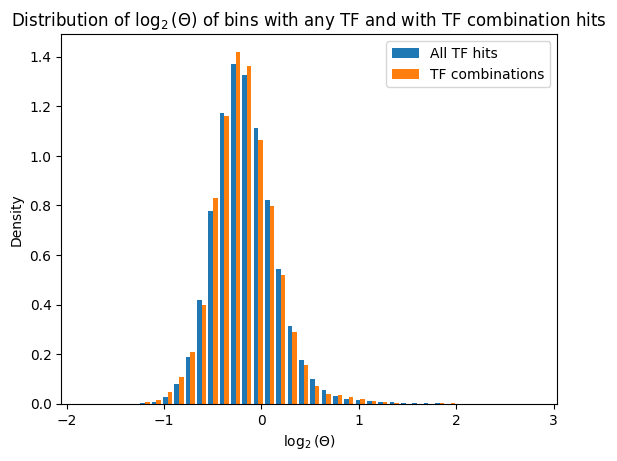

In [36]:
h = plt.hist((hits_db.df()['log2FC'],
              TFcomb_hits['log2FC']),
             bins=40, density=True, label=('All TF hits', 'TF combinations'))
plt.xlabel('$\log_2(\Theta)$')
plt.ylabel('Density')
plt.title('Distribution of $\log_2(\Theta)$ of bins with any TF and with TF combination hits')
plt.legend(loc='upper right')

#### Distances between TF motif pairs in sequence bins

Text(0.5, 1.0, 'Distribution of distances between TFs on sequence bins')

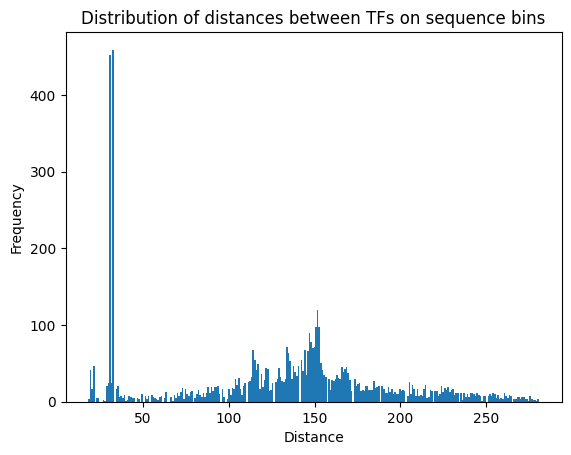

In [42]:
h = plt.hist(TFcomb_hits['motif_dist'], bins=280)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Distribution of distances between TFs on sequence bins')


The overall distribution is distorted by a few TF motif combinations predominating at certain distances (such as ZNF135 and ZNF460 at distances 31 and 33).

In [43]:
duckdb.sql('select motif_names, motif_dist, count(*) as num_seqs, '
           'min(log2FC), median(log2FC), max(log2FC), '
           'sum(cast(train as int)) as in_train, sum(cast(test as int)) as in_test '
           'from TFcomb_hits '
           'group by motif_names, motif_dist '
           'having num_seqs > 40').df()

,motif_names,motif_dist,num_seqs,min(log2FC),median(log2FC),max(log2FC),in_train,in_test
0,"ZNF8, ZNF140",152,46,-0.59935,-0.157255,0.23606,8.0,6.0
1,"ZNF140, ZNF8",152,44,-0.58550,-0.185965,0.24456,5.0,8.0
2,"ZNF135, ZNF460",33,459,-1.09289,-0.167750,0.89688,72.0,68.0
3,"ZNF140, ZNF8",153,49,-0.74845,-0.163580,0.39611,9.0,7.0
4,"THRA, ZNF460",114,43,-0.63331,-0.186920,0.81288,4.0,6.0
5,"ZNF460, ZNF135",31,438,-1.05330,-0.182475,0.53570,58.0,59.0
6,"ZNF460, THRA",21,44,-0.66615,-0.257580,0.39699,3.0,8.0
